In [156]:
import torch
import seaborn as sns
from torch import distributions

from torch import nn, optim
import math
from tqdm import tqdm

from pyro import distributions as dist
from pyro.distributions import transforms as T
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
mmin = 4.59
mmax = 86.22

In [125]:
def pm1(m1, alpha=2.63, mum=33.07, sigmam=5.69, lpeak=0.1):
    m1p = m1.clone()
    m1p = (alpha - 1) / mmin * (m1p / mmin) ** -alpha
    m1p[m1 < mmin] = 1e-9    
    m1g = m1.clone()
    m1g = 1 / sigmam * 1 / math.sqrt(math.pi * 2) * torch.exp(-0.5 * (m1g - mum) ** 2 / sigmam ** 2) 
    return (1 - lpeak) * m1p + lpeak * m1g

In [126]:
m = torch.linspace(0, 100, 1024)

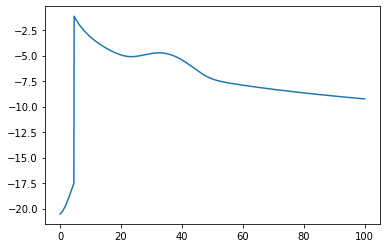

In [127]:
plt.plot(m, pm1(m).log())

In [128]:
def trapezoid(fx, deltax):
    return (fx[:-1] + fx[1:]) / 2 * deltax

In [129]:
x = torch.linspace(mmin, 1024, 32768)
dx = x[1] - x[0]

In [130]:
trapezoid(pm1(x), dx).sum()

tensor(0.9999)

In [173]:
def pq(q, beta=1.26):
    qc = q.clone()
    qc = qc ** beta
    qc[q <= 0] = 1e-9
    qc[q > 1] = 1e-9
    return qc

In [174]:
def px(x, q, mux0=0.19, gamma=1.08, log10sx0=-1.06, alpha=-0.46, beta=-0.83):
    mux = mux0 + alpha*(q - 0.5)
    log10sx = log10sx0 + beta * (q - 0.5)
    sx = 10 ** log10sx
    return torch.exp(-0.5 * (x - mux) ** 2 / sx ** 2)

In [175]:
x = torch.linspace(-3, 3, 1024)


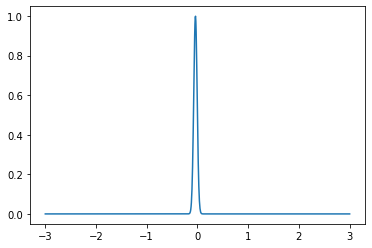

In [176]:
plt.plot(x, px(x, 1))

In [212]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18 as cosmo

z_axis = np.linspace(0,10,100000)
dVdz = cosmo.differential_comoving_volume(z_axis).value/1e9*4*np.pi # Astropy dVcdz is per stradian
dVdz_interp = interp1d(z_axis,dVdz)

def z_distribution_unnormalized(z):
    z = z.clone().numpy()
    return torch.from_numpy(dVdz_interp(z)*(1+z)**1.7)


In [202]:
@torch.no_grad()
def rejection_sampling(fn, rng, num_samples=1024, batch_size=32768, max_log_prob=0, n_dims=1):
    z = torch.Tensor()
    i = 0
    while len(z) < num_samples:
        eps = torch.rand((num_samples, n_dims))
        min, max = rng
        z_ = eps * (max - min) + min
        prob = torch.rand(num_samples)

        logprob = fn(z_).squeeze()
        assert not torch.any(logprob > max_log_prob), (logprob.max(), max_log_prob)
        prob_ = torch.exp(logprob - max_log_prob)
        accept = prob_ > prob
        z = torch.cat([z, z_[accept, :]])
        i += 1
    return z[:num_samples]

In [203]:
m1 = rejection_sampling(lambda x: pm1(x).log(), (mmin, mmax))

In [204]:
q = rejection_sampling(lambda x: pq(x).log(), (0, 1))

In [215]:
Xeff = []
for q_ in q:
    Xeff.append(rejection_sampling(lambda x: px(x, q_).log(), (-1, 1), max_log_prob=0, num_samples=1))
    
Xeff = torch.cat(Xeff)
    

<AxesSubplot:ylabel='Density'>

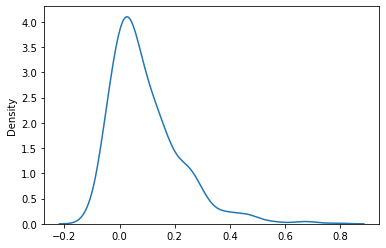

In [216]:
sns.kdeplot(Xeff.squeeze())

In [219]:
z = rejection_sampling(lambda x: z_distribution_unnormalized(x).log(), (0, 10), max_log_prob=10)

In [225]:
data = torch.cat([m1, q, Xeff, z], dim=-1)

In [227]:
import corner

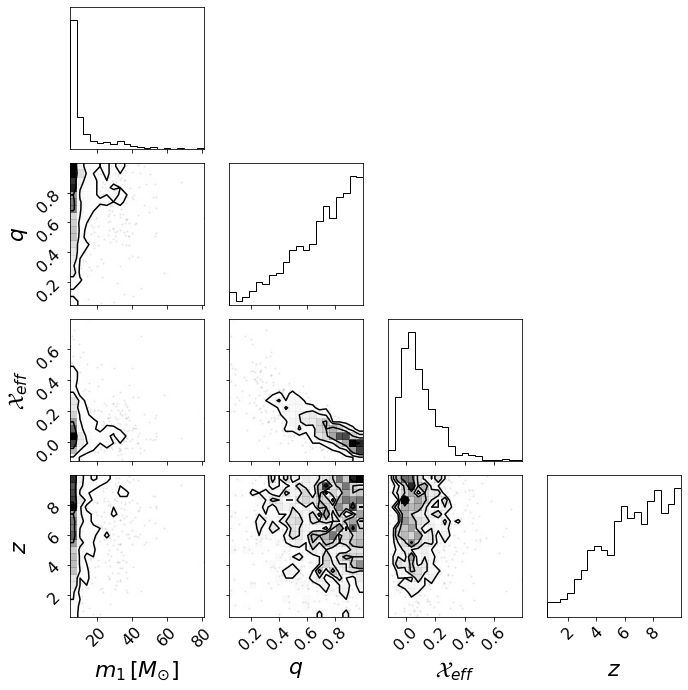

In [230]:
fig = corner.corner(data.numpy(), labels=[r"$m_1\, [M_{\odot}]$", r"$q$", r"$\mathcal{X}_{eff}$", r"$z$"], label_kwargs=dict(fontsize=22))

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=16)
plt.tight_layout()

# fig.subplots_adjust(right=1.5,top=1.5)
plt.savefig('corner.pdf', bbox_inches='tight')





In [231]:
torch.save(data, 'data.pth')